In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
EMBEDD_FILE = os.path.join("gensim", "embedd_weights.npy")
X_FILE_BIN =  os.path.join("gensim", "embedded_X.npy")
Y_FILE_BIN =  os.path.join("gensim", "encoded_Y.npy")

In [3]:
gensim_weights = np.matrix(np.load(EMBEDD_FILE))

In [4]:
gensim_weights.dtype

dtype('float32')

In [5]:
X = np.load(X_FILE_BIN)
Y = np.load(Y_FILE_BIN)

In [6]:
X.dtype

dtype('int32')

In [7]:
gensim_weights.shape, X.shape, Y.shape

((59717, 300), (838804, 679), (838804,))

In [8]:
NUM_WORDS = gensim_weights.shape[0]
EMBEDD_DIM = gensim_weights.shape[1]
PADDED_LEN = X.shape[1]

In [9]:
n_total = X.shape[0]
n_skip = 450_000 # 0
n_train = 500_000
n_val = 10_000 # 200_000
n_test = n_total - n_train - n_val

X_train = X[n_skip:n_train]
Y_train = to_categorical(Y[n_skip:n_train])

X_val = X[n_train:n_train+n_val]
Y_val = to_categorical(Y[n_train:n_train+n_val])

X_test = X[-n_test:]
Y_test = to_categorical(Y[-n_test:])

In [10]:
# compute class weights for keras (obtained from the whole of train sample)

classes = np.unique(Y[:n_train])
n_classes = len(classes)

class_weights = compute_class_weight('balanced', classes, Y[:n_train])  # ~ 1 / np.unique(Y, return_counts=True)[1]
class_weights

array([ 0.27602776,  0.72736371, 13.23801959,  9.49559404, 30.29201502,
        1.26825655])

In [11]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

# weighted categorical crossentropy
def w_cat_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = class_weights * class_entropy
    return -K.mean(weighted_entropy)/100

In [12]:
# some other global learning settings

batch_size = 2000
patience = 4
optimizer = 'adam' # 'rmsprop'
my_loss = fuzzy_macroF1_flip
my_metrics = ['categorical_accuracy', macroF1, w_cat_crossE,] # macroPrec, macroRecall,

In [13]:
# auxiliary functions
    
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r', 'g', 'y', 'c', 'm', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history.history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    
    
# choose callback functions to be given in model.fit(...)
# the EarlyStoppping maybe set to monitor different things, like the batchwise macroF1 of ours
def callbacks(LRfactor=0.8):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
            #EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
            EarlyStopping(monitor='val_loss', patience=patience)
           ]

---

In [15]:
model = Sequential()
model.add(Embedding(input_dim=NUM_WORDS, output_dim=EMBEDD_DIM, input_length=PADDED_LEN))
model.add(Conv1D(48, 3))
model.add(MaxPooling1D(8, 4))
model.add(Conv1D(12, 4))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 677, 48)           43248     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 168, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 165, 12)           2316      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1980)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 11886     
Total params: 17,972,550
Trainable params: 17,972,550
Non-trainable params: 0
________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=my_metrics)

In [20]:
history = model.fit(X_train,Y_train,
                    class_weight=class_weights,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks())

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 320s 6ms/step - loss: 1.0839 - categorical_accuracy: 0.6038 - macroF1: 0.1315 - macroPrec: 0.1528 - macroRecall: 0.1413 - w_cat_crossE: 9.8601 - val_loss: 0.8594 - val_categorical_accuracy: 0.6567 - val_macroF1: 0.1887 - val_macroPrec: 0.2353 - val_macroRecall: 0.1936 - val_w_cat_crossE: 8.9958
Epoch 2/30
50000/50000 [==============================] - 314s 6ms/step - loss: 0.6018 - categorical_accuracy: 0.7887 - macroF1: 0.2881 - macroPrec: 0.3582 - macroRecall: 0.2789 - w_cat_crossE: 7.9962 - val_loss: 0.4363 - val_categorical_accuracy: 0.8544 - val_macroF1: 0.3853 - val_macroPrec: 0.4152 - val_macroRecall: 0.3708 - val_w_cat_crossE: 6.9855
Epoch 3/30
50000/50000 [==============================] - 319s 6ms/step - loss: 0.3605 - categorical_accuracy: 0.8831 - macroF1: 0.4187 - macroPrec: 0.4274 - macroRecall: 0.4119 - w_cat_crossE: 6.0735 - val_loss: 0.3338 - val_categorical_accu

KeyboardInterrupt: 

---

In [24]:
model2 = Sequential()
model2.add(Embedding(input_dim=NUM_WORDS, output_dim=EMBEDD_DIM, input_length=PADDED_LEN,\
                     weights=[gensim_weights], trainable=True))
model2.add(Conv1D(48, 3))
model2.add(MaxPooling1D(8, 4))
model2.add(Conv1D(12, 4))
model2.add(Flatten())
model2.add(Dense(n_classes, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 677, 48)           43248     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 168, 48)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 165, 12)           2316      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1980)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11886     
Total params: 17,972,550
Trainable params: 57,450
Non-trainable params: 17,915,100
___________________________________________________________

In [25]:
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=my_metrics)

In [26]:
model2.fit(X_train, Y_train,\
           class_weight=class_weights,
           epochs=30,
           batch_size=batch_size,
           validation_data=(X_val, Y_val),
           callbacks=callbacks())

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 150s 3ms/step - loss: 1.3390 - categorical_accuracy: 0.5838 - macroF1: 0.0602 - w_cat_crossE: 8.3672 - val_loss: 1.0983 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1257 - val_w_cat_crossE: 10.6121
Epoch 2/30
50000/50000 [==============================] - 149s 3ms/step - loss: 1.0736 - categorical_accuracy: 0.6024 - macroF1: 0.1254 - w_cat_crossE: 10.0598 - val_loss: 1.0647 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.2511
Epoch 3/30
50000/50000 [==============================] - 148s 3ms/step - loss: 1.0587 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 9.9541 - val_loss: 1.0527 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.6521
Epoch 4/30
50000/50000 [==============================] - 148s 3ms/step - loss: 1.0415 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 9.8550 - v

---

---

In [14]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, class_weight=class_weights, callbacks=callbacks(),\
                 custom_embedd=False, embedd_weights = [gensim_weights],\
                 embedd_dims=[NUM_WORDS, EMBEDD_DIM, PADDED_LEN], train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.class_weight = class_weight
        self.callbacks = callbacks
        self.input_dim = embedd_dims[0] # num_words
        self.output_dim = embedd_dims[1] # dimension of the embedding space
        self.input_length = embedd_dims[2] # padded_length
        self.train_weigts = train_weights
        self.history = None
        self.results = None
        
        self.model = Sequential()
        
        if custom_embedd:
            self.embedd_weights = embedd_weights
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts))
            self.model.layers[0].trainable = False  # szczeżonego panbug szczeże
        else:
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     trainable=True))            
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, Y_train,
            class_weight=self.class_weight,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.results
    
    def plot(self):
        plot_history(self.history)
        
    def Ksave(self, file):
        self.model.save(file)
        
    def save(self, file):
        pickle.dump(self, file)
 


---
---

# Loss = *categorical_crossentropy*

---

### Dense nets

In [15]:
# embedding: keras layer, trained
# structure: dense layers

layers1a = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu'),
            Flatten()
          ]

model1a = BlackBox(layers=layers1a, loss='categorical_crossentropy', metrics=my_metrics)
model1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 300)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 168, 144)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 144)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 168, 96)           13920     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
__________

In [16]:
model1a.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 568s 11ms/step - loss: 1.0612 - categorical_accuracy: 0.6120 - macroF1: 0.1174 - w_cat_crossE: 9.7652 - val_loss: 0.8007 - val_categorical_accuracy: 0.7099 - val_macroF1: 0.2115 - val_w_cat_crossE: 8.0099
Epoch 2/50
50000/50000 [==============================] - 621s 12ms/step - loss: 0.5063 - categorical_accuracy: 0.8310 - macroF1: 0.3573 - w_cat_crossE: 7.5247 - val_loss: 0.3304 - val_categorical_accuracy: 0.8990 - val_macroF1: 0.4364 - val_w_cat_crossE: 5.3409
Epoch 3/50
50000/50000 [==============================] - 638s 13ms/step - loss: 0.2713 - categorical_accuracy: 0.9129 - macroF1: 0.4520 - w_cat_crossE: 5.2618 - val_loss: 0.2848 - val_categorical_accuracy: 0.9112 - val_macroF1: 0.4663 - val_w_cat_crossE: 4.3533
Epoch 4/50
50000/50000 [==============================] - 643s 13ms/step - loss: 0.1920 - categorical_accuracy: 0.9361 - macroF1: 0.4970 - w_cat_crossE: 4.0851 -

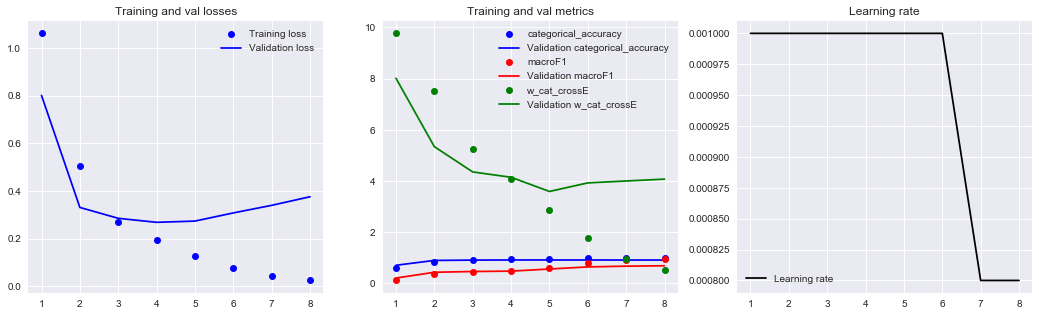

In [22]:
model1a.plot()

---

In [17]:
# embedding: gensim weights, re-trained
# structure: dense layers

layers1b = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu'),
            Flatten()
          ]

model1b = BlackBox(layers=layers1b, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=True)
model1b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
dropout_3 (Dropout)          (None, 679, 300)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 168, 144)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 168, 144)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 168, 96)           13920     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16128)             0         
__________

In [18]:
model1b.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 409s 8ms/step - loss: 1.2852 - categorical_accuracy: 0.5840 - macroF1: 0.0712 - w_cat_crossE: 9.2552 - val_loss: 1.0751 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 10.6364
Epoch 2/50
50000/50000 [==============================] - 411s 8ms/step - loss: 1.0683 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 9.8765 - val_loss: 1.0614 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.5040
Epoch 3/50
50000/50000 [==============================] - 415s 8ms/step - loss: 1.0550 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 9.9660 - val_loss: 1.0426 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.4981
Epoch 4/50
50000/50000 [==============================] - 409s 8ms/step - loss: 1.0216 - categorical_accuracy: 0.6047 - macroF1: 0.1256 - w_cat_crossE: 9.8854 - va

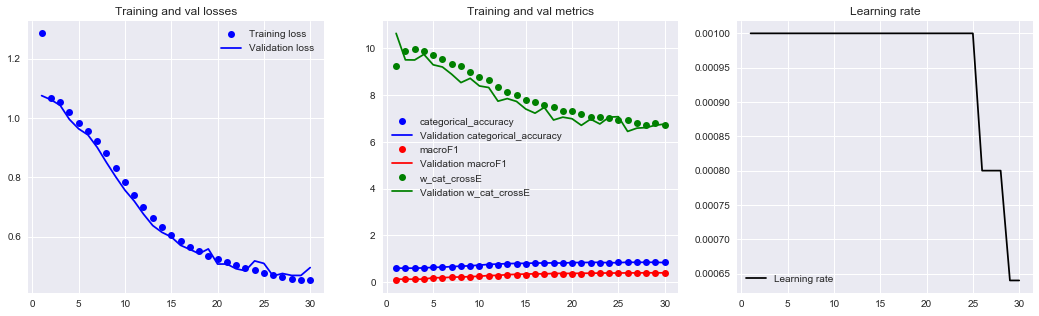

In [21]:
model1b.plot()

---

In [19]:
# embedding: gensim weights, not-trained
# structure: dense layers

layers1c = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu'),
            Flatten()
          ]

model1c = BlackBox(layers=layers1c, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=False)
model1c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
dropout_5 (Dropout)          (None, 679, 300)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 168, 144)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 168, 144)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 168, 96)           13920     
_________________________________________________________________
flatten_3 (Flatten)          (None, 16128)             0         
__________

In [20]:
model1c.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 412s 8ms/step - loss: 1.2806 - categorical_accuracy: 0.5817 - macroF1: 0.0620 - w_cat_crossE: 9.1097 - val_loss: 1.0755 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 10.2968
Epoch 2/50
50000/50000 [==============================] - 416s 8ms/step - loss: 1.0689 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 9.8449 - val_loss: 1.0624 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.7787
Epoch 3/50
50000/50000 [==============================] - 408s 8ms/step - loss: 1.0572 - categorical_accuracy: 0.6024 - macroF1: 0.1253 - w_cat_crossE: 10.0294 - val_loss: 1.0488 - val_categorical_accuracy: 0.5967 - val_macroF1: 0.1245 - val_w_cat_crossE: 9.4307
Epoch 4/50
50000/50000 [==============================] - 409s 8ms/step - loss: 1.0274 - categorical_accuracy: 0.6025 - macroF1: 0.1255 - w_cat_crossE: 9.8897 - v

KeyboardInterrupt: 

---

### Convolutions

In [ ]:
# embedding: keras layer, trained
# structure: convolution layers

layers2a = [Dropout(0.1),
            Conv1D(48, 3),
            MaxPooling1D(8, 4),
            Dropout(0.1),
            Conv1D(12, 4),
            Flatten()
           ]

model2a = BlackBox(layers=layers2a, loss='categorical_crossentropy', metrics=my_metrics)
model2a.summary()

In [ ]:
model2a.fit()

---

In [ ]:
# embedding: gensim weights, re-trained
# structure: convolution layers

layers2b = [Dropout(0.1),
            Conv1D(48, 3),
            MaxPooling1D(8, 4),
            Dropout(0.1),
            Conv1D(12, 4),
            Flatten()
           ]

model2b = BlackBox(layers=layers2b, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=True)
model2b.summary()

In [ ]:
model2b.fit()

---

In [20]:
# embedding: gensim weights, not-trained
# structure: convolution layers

layers2c = [Dropout(0.1),
            Conv1D(48, 3),
            MaxPooling1D(8, 4),
            Dropout(0.1),
            Conv1D(12, 4),
            Flatten()
           ]

model2c = BlackBox(layers=layers2c, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=False)
model2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
dropout_5 (Dropout)          (None, 679, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 677, 48)           43248     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 168, 48)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 168, 48)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 165, 12)           2316      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1980)              0         
__________

In [21]:
model2c.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 2000/50000 [>.............................] - ETA: 5:44 - loss: 1.7919 - categorical_accuracy: 0.0870 - macroF1: 0.0000e+00 - w_cat_crossE: 6.6601

KeyboardInterrupt: 

---

### Recurrent NNEts

In [46]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers3a = [Bidirectional(SimpleRNN(70, dropout=0.1, recurrent_dropout=0.1)),
            Dense(30, activation='relu')
           ]

model3a = BlackBox(layers=layers3a, loss='categorical_crossentropy', metrics=my_metrics)
model3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 140)               51940     
_________________________________________________________________
dense_49 (Dense)             (None, 30)                4230      
_________________________________________________________________
dense_50 (Dense)             (None, 6)                 186       
Total params: 17,971,456
Trainable params: 17,971,456
Non-trainable params: 0
_________________________________________________________________


---

In [45]:
# embedding: gensim weights, re-trained
# structure: birectional fully connected RNN layer + dense

layers3b = [Bidirectional(SimpleRNN(70, dropout=0.1, recurrent_dropout=0.1)),
            Dense(30, activation='relu')
           ]

model3b = BlackBox(layers=layers3b, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=True)
model3b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 140)               51940     
_________________________________________________________________
dense_47 (Dense)             (None, 30)                4230      
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 186       
Total params: 17,971,456
Trainable params: 56,356
Non-trainable params: 17,915,100
_________________________________________________________________


---

In [22]:
# embedding: gensim weights, not-trained
# structure: birectional fully connected RNN layer + dense

layers3c = [Bidirectional(SimpleRNN(70, dropout=0.1, recurrent_dropout=0.1)),
            Dense(30, activation='relu')
           ]

model3c = BlackBox(layers=layers3c, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=False)
model3c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140)               51940     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                4230      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 186       
Total params: 17,971,456
Trainable params: 56,356
Non-trainable params: 17,915,100
_________________________________________________________________


In [23]:
model3c.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50


KeyboardInterrupt: 

---

### Short-Long-Term-Memory

In [ ]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers4a = [Bidirectional(LSTM(70, dropout=0.1, recurrent_dropout=0.1)),
            Dense(30, activation='relu')
           ]

model4a = BlackBox(layers=layers4a, loss='categorical_crossentropy', metrics=my_metrics)
model4a.summary()

---

In [56]:
# embedding: gensim weights, re-trained
# structure: birectional fully connected RNN layer + dense

layers4b = [Bidirectional(LSTM(22, dropout=0.1, recurrent_dropout=0.1))
           ]

model4b = BlackBox(layers=layers4b, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=True)
model4b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 44)                56848     
_________________________________________________________________
dense_61 (Dense)             (None, 6)                 270       
Total params: 17,972,218
Trainable params: 57,118
Non-trainable params: 17,915,100
_________________________________________________________________


---

In [24]:
# embedding: gensim weights, not-trained
# structure: birectional fully connected RNN layer + dense

layers4c = [Bidirectional(LSTM(22, dropout=0.1, recurrent_dropout=0.1))
           ]

model4c = BlackBox(layers=layers4c, loss='categorical_crossentropy', metrics=my_metrics, custom_embedd=True, train_weights=False)
model4c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 679, 300)          17915100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 44)                56848     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 270       
Total params: 17,972,218
Trainable params: 57,118
Non-trainable params: 17,915,100
_________________________________________________________________


In [ ]:
model4c.fit()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50


---
---

# Loss = fuzzy_macroF1_flip

---

### Dense nets

In [58]:
# embedding: keras layer, trained
# structure: dense layers

layers5a = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu')
          ]

model5a = BlackBox(layers=layers5a, loss=fuzzy_macroF1_flip, metrics=my_metrics, class_weight=None)
model5a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
dropout_32 (Dropout)         (None, 679, 300)          0         
_________________________________________________________________
dense_63 (Dense)             (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 168, 144)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 168, 144)          0         
_________________________________________________________________
dense_64 (Dense)             (None, 168, 96)           13920     
_________________________________________________________________
dense_65 (Dense)             (None, 168, 6)            582       
Total para

---

In [59]:
# embedding: gensim weights, re-trained
# structure: dense layers

layers5b = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu')
          ]

model5b = BlackBox(layers=layers5b, loss=fuzzy_macroF1_flip, metrics=my_metrics, class_weight=None,\
                   custom_embedd=True, train_weights=True)
model5b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
dropout_34 (Dropout)         (None, 679, 300)          0         
_________________________________________________________________
dense_66 (Dense)             (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 168, 144)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 168, 144)          0         
_________________________________________________________________
dense_67 (Dense)             (None, 168, 96)           13920     
_________________________________________________________________
dense_68 (Dense)             (None, 168, 6)            582       
Total para

---

In [60]:
# embedding: gensim weights, not-trained
# structure: dense layers

layers5c = [Dropout(0.1),
           Dense(144, activation='relu'),
           MaxPooling1D(8, 4),
           Dropout(0.1),
           Dense(96, activation='relu')
          ]

model5c = BlackBox(layers=layers5c, loss=fuzzy_macroF1_flip, metrics=my_metrics, class_weight=None,\
                   custom_embedd=True, train_weights=False)
model5c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 679, 300)          17915100  
_________________________________________________________________
dropout_36 (Dropout)         (None, 679, 300)          0         
_________________________________________________________________
dense_69 (Dense)             (None, 679, 144)          43344     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 168, 144)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 168, 144)          0         
_________________________________________________________________
dense_70 (Dense)             (None, 168, 96)           13920     
_________________________________________________________________
dense_71 (Dense)             (None, 168, 6)            582       
Total para

---